# LeNet 5



In [1]:
from algorithms import *
from lenet5 import *
import utils
import numpy as np
import matplotlib.pyplot as plt

data_workers, y_workers, lenet5, right_pred_data, right_pred_labels,  test_x, test_y =  utils.get_data()

epsilon = 0.25
d = 28*28

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
9826
step 10
(10, 100, 28, 28, 1)
(10, 100, 28, 28, 1)


# Universal Adversarial Attacks

## Decentralized Stochastic Gradient Free FW

### Offline run and results

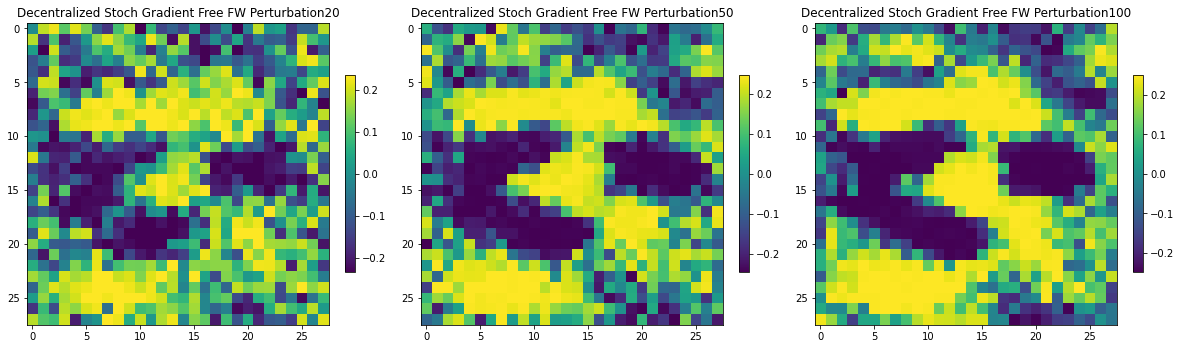

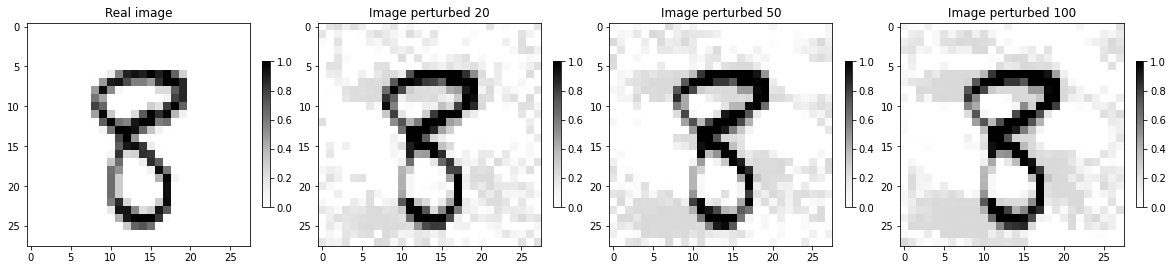

Model Image perturbed 20 prediction is:  3
Model Image perturbed 50 prediction is:  3
Model Image perturbed 100 prediction is:  3


In [2]:
directory = "../data/perturbations/decentralized_stoch/"
Ts = [20, 50 ,100]
deltas = []
for T in Ts:
    deltas.append(np.load(f'{directory}report_perturbation_m15_T{T}.npy'))

n_rows, n_columns = 1, 3
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 20))

###### Perturbation plots
for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbation(delta, f'Decentralized Stoch Gradient Free FW Perturbation{Ts[idx]}',
                                      axes[idx])
plt.show()

###### Image perturbed plots
idx_image = np.random.randint(low=0, high=right_pred_data.shape[0])
image_test = right_pred_data[idx_image].numpy()
fig, axes = plt.subplots(n_rows, n_columns+1, figsize=(20, 20))
img = axes[0].imshow(image_test.reshape(28,28), cmap='Greys')
axes[0].set_title('Real image')
fig.colorbar(img, ax=axes[0], fraction=0.03, pad=0.05)

for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbed(delta, image_test, f'Image perturbed {Ts[idx]}', axes[idx+1])
plt.show()
for idx, delta in enumerate(deltas):
    prediction = utils.predict_single_img_perturbation(lenet5, image_test, delta)
    print( f'Model Image perturbed {Ts[idx]} prediction is: ', prediction)

Instead the overall error/loss made by the model on the perturbed images are summarized in the following cell

In [3]:
for idx, delta in enumerate(deltas):
    evaluation = utils.evaluate_perturbed_images(lenet5, right_pred_data, right_pred_labels, delta, verbose=0)
    print( f'Model {idx+1} with {Ts[idx]} iterations: \n\t Error/loss: {evaluation[0]} \n\t Accuracy: {evaluation[1]}\n')

Model 1 with 20 iterations: 
	 Error/loss: 2.035454511642456 
	 Accuracy: 0.5525137186050415

Model 2 with 50 iterations: 
	 Error/loss: 3.5296566486358643 
	 Accuracy: 0.3945654332637787

Model 3 with 100 iterations: 
	 Error/loss: 3.785723924636841 
	 Accuracy: 0.36871564388275146



#### Gaussian noise comparison

A little comparison with guassian noise

308/308 [==============================] - 2s 6ms/step - loss: 0.3298 - accuracy: 0.8931


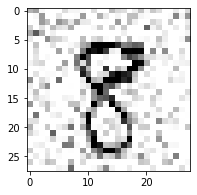

In [4]:
# Gaussian noise
gaussian_noise_data = right_pred_data + np.random.normal(0, 0.3, right_pred_data.shape)
gaussian_noise_data = np.clip(gaussian_noise_data, 0., 1.)
lenet5.model.evaluate(gaussian_noise_data, right_pred_labels)
guass_noise_image = gaussian_noise_data[idx_image]
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(guass_noise_image, cmap='Greys')
plt.show()

We can see that the model is able to correctly classify, with high accuracy, images showing more visible noise using Gaussian noise than our perturbations.
Hence the perturbation found by our model is at first imperceptible to human eyes, and even though the noise is less perceptible to us the model is not able to categorize the image with the right label. **Da scrivere meglio forse. vi suona imperceptible e perceptible, volevo solo illustrare un bel esempio per i confronti dei noise** 

### Example of Model training and online results

We now show an example of run for the **Decentralized Stochastic Gradient Free FW** method applied to MNIST dataset for an **Adversarial attack**

In [ ]:
d = 28*28 #dimension
M = 10 # number of workers
m = 15 # directions
T = 10 # iterations
deltas = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
delta = deltas[-1]
utils.plot_perturbation(delta, f'Decentralized Stoch Gradient Free FW Perturbation', figsize=(3,3))
utils.plot_perturbed_img(perturbation=delta, image_test=image_test, figsize=(7,7))
prediction = utils.predict_single_img_perturbation(lenet5, image_test, delta)
print( f'Model Image perturbed prediction is: ', prediction[0])

The overall errors made by the model is summarized in the following result.

In [ ]:
evaluation = utils.evaluate_perturbed_images(lenet5, right_pred_data, right_pred_labels, delta, verbose=0)
print( f'Decentralized Stochastic Gradient Free FW Method: \n\n\t Error/loss: {evaluation[0]} \n\t Accuracy: {evaluation[1]}\n')

# Decentralized Variance-Reduced Zeroth-Order FW

### Offline run and results

In [ ]:
directory = "../data/perturbations/reduced_variance/"
files_delta = ['perturbation_variance_charming.npy']
deltas = []
for file in files_delta:
    deltas.append(np.load(f'{file}.npy'))

n_rows, n_columns = 1, 1
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 20))

###### Perturbation plots
for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbation(delta, f'Decentralized Stoch Gradient Free FW Perturbation{Ts[idx]}',
                                      axes[idx])
plt.show()

###### Image perturbed plots
idx_image = np.random.randint(low=0, high=right_pred_data.shape[0])
image_test = right_pred_data[idx_image].numpy()
fig, axes = plt.subplots(n_rows, n_columns+1, figsize=(20, 20))
img = axes[0].imshow(image_test.reshape(28,28), cmap='Greys')
axes[0].set_title('Real image')
fig.colorbar(img, ax=axes[0], fraction=0.03, pad=0.05)

for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbed(delta, image_test, f'Image perturbed {Ts[idx]}', axes[idx+1])
plt.show()
for idx, delta in enumerate(deltas):
    prediction = utils.predict_single_img_perturbation(lenet5, image_test, delta)
    print( f'Model Image perturbed {Ts[idx]} prediction is: ', prediction)

# Distributed Zeroth-Order FW

In [ ]:
directory = "../data/perturbations/distributed/"
Ts = [20, 50 ,100]
deltas = []
for T in Ts:
    print(f'Best delta workers calculation for Model with {T} iterations')
    print('Loading...')
    delta_workers = np.load(f'{directory}report_distributed_delta_{T}_15.npy')
    best_delta, worker_idx = utils.get_distributed_best_delta(lenet5, right_pred_data, right_pred_labels, delta_workers, verbose=1)
    print(f'Best delta is from {worker_idx+1}th worker')
    deltas.append(best_delta)

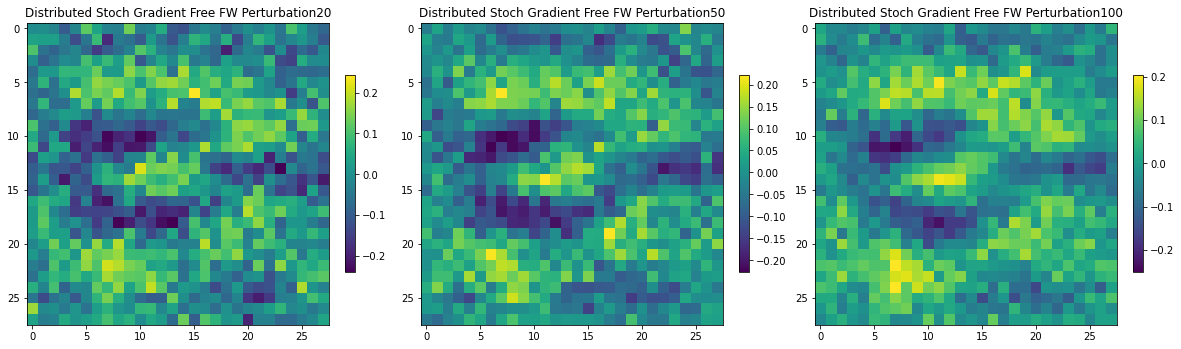

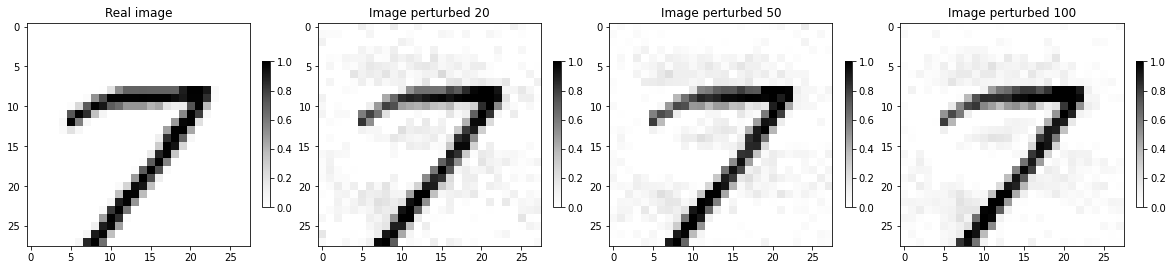

Model Image perturbed 20 prediction is:  3
Model Image perturbed 50 prediction is:  3
Model Image perturbed 100 prediction is:  3


In [6]:
n_rows, n_columns = 1, 3
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 20))
###### Perturbation plots
for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbation(delta, f'Distributed Stoch Gradient Free FW Perturbation{Ts[idx]}',
                                      axes[idx])
plt.show()

###### Image perturbed plots
idx_image = np.random.randint(low=0, high=right_pred_data.shape[0])
image_test = right_pred_data[idx_image].numpy()
fig, axes = plt.subplots(n_rows, n_columns+1, figsize=(20, 20))
img = axes[0].imshow(image_test.reshape(28,28), cmap='Greys')
axes[0].set_title('Real image')
fig.colorbar(img, ax=axes[0], fraction=0.03, pad=0.05)

for idx, delta in enumerate(deltas):
    axis, img = utils.get_image_perturbed(delta, image_test, f'Image perturbed {Ts[idx]}', axes[idx+1])
plt.show()
for idx, delta in enumerate(deltas):
    prediction = utils.predict_single_img_perturbation(lenet5, image_test, delta)
    print( f'Model Image perturbed {Ts[idx]} prediction is: ', prediction)

**Bisogna stare attenti qua che ho vistoche il modello a volte nonostante con la noise predice la label giusta, infatti l'accuracy generale e` attorno al 70 percento**

In [4]:
for idx, delta in enumerate(deltas):
    evaluation = utils.evaluate_perturbed_images(lenet5, right_pred_data, right_pred_labels, delta, verbose=0)
    print( f'Model {idx+1} with {Ts[idx]} iterations: \n\t Error/loss: {evaluation[0]} \n\t Accuracy: {evaluation[1]}\n')

Model 1 with 20 iterations: 
	 Error/loss: 1.0775240659713745 
	 Accuracy: 0.7346835136413574

Model 2 with 50 iterations: 
	 Error/loss: 0.9584702253341675 
	 Accuracy: 0.7461835741996765

Model 3 with 100 iterations: 
	 Error/loss: 0.9305565357208252 
	 Accuracy: 0.7583960890769958

